In [1]:
# Impoting required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.lines as mlines

# setting default option
pd.set_option("mode.copy_on_write", True)
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
# loading the Dataset
mortality = pd.read_parquet("../../01_Data/02_Processed/03_Mortality_Final.parquet")

In [3]:
mortality.sample(5)

,State,State_Code,County,County_Code,Year,Deaths,Population,Mortality_Rate
8751,Oregon,OR,LANE,41039,2004,23,332327.0,0.000069
7595,North Carolina,NC,NEW HANOVER,37129,2006,19,190791.0,0.000100
6933,New York,NY,QUEENS,36081,2007,132,2177351.0,0.000061
91,Alabama,AL,DE KALB,01049,2010,7,71133.0,0.000098
8420,Ohio,OH,WARREN,39165,2010,24,213445.0,0.000112


In [4]:
# Mortality Multiplier
mort_mul = 100000
mortality["Mortality_mul"] = mortality["Mortality_Rate"] * mort_mul

# Global Setting for ylabels so that they are consistent across all plots
ylabels = f"Mortality per {mort_mul:_} Population"

In [5]:
# Subset the dataset for the analysis
def prepare_data(
    dataset, test_state, control_states, policy_year, start_year, end_year
):
    # Filter states
    state_list = [test_state] + control_states
    sub_dataset = dataset[dataset["State_Code"].isin(state_list)]

    # Filter years
    sub_dataset = sub_dataset[
        (sub_dataset["Year"] >= start_year) & (sub_dataset["Year"] <= end_year)
    ]

    # Tagging for pre-post policy implementation and test-control
    sub_dataset["policy_implementation"] = sub_dataset["Year"] >= policy_year
    sub_dataset["State_Type"] = sub_dataset["State_Code"].apply(
        lambda x: "Test" if x == test_state else "Control"
    )

    return sub_dataset

In [6]:
def plot_pre_post_policy_graph(dataset_in, test_state, policy_year, metric_column):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    # Convert YEAR and metric_column to float64
    dataset = dataset_in.copy()  # Copy to avoid changing the original dataframe
    # dataset["YEAR"] = dataset["YEAR"].astype("float64")
    # dataset[metric_column] = dataset[metric_column].astype("float64")

    sns.regplot(
        data=dataset[
            (dataset["State_Code"] == test_state)
            & (dataset["policy_implementation"] == True)
        ],
        x="Year",
        y=metric_column,
        line_kws={"color": "red"},
        ax=ax,
        scatter=False,
    )

    sns.regplot(
        data=dataset[
            (dataset["State_Code"] == test_state)
            & (dataset["policy_implementation"] != True)
        ],
        x="Year",
        y=metric_column,
        line_kws={"color": "blue"},
        ax=ax,
        scatter=False,
    )

    ax.axvline(policy_year, ls="--", color="orange")

    plt.legend(
        handles=[
            mlines.Line2D([], [], color="blue", label="Pre-Policy"),
            mlines.Line2D([], [], color="red", label="Post-Policy"),
        ],
        loc="lower right",
    )

    plt.title(f"Pre-Post Policy Implementation Trend for Mortality: {test_state}")
    plt.ylabel(ylabels)

    plt.show()

In [7]:
def plot_diff_in_diff_graph(dataset_in, test_state, policy_year, metric_column):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    # Convert YEAR and metric_column to float64
    dataset = dataset_in.copy()  # Copy to avoid changing the original dataframe
    # dataset["YEAR"] = dataset["YEAR"].astype("float64")
    # dataset[metric_column] = dataset[metric_column].astype("float64")

    # Plotting for test state - pre-policy
    sns.regplot(
        data=dataset[
            (dataset["State_Type"] == "Test")
            & (dataset["policy_implementation"] != True)
        ],
        x="Year",
        y=metric_column,
        line_kws={"color": "blue"},
        ax=ax,
        scatter=False,
    )

    # Plotting for test state - post-policy
    sns.regplot(
        data=dataset[
            (dataset["State_Type"] == "Test")
            & (dataset["policy_implementation"] == True)
        ],
        x="Year",
        y=metric_column,
        line_kws={"color": "blue"},
        ax=ax,
        scatter=False,
    )

    # Plotting for control states - pre-policy
    sns.regplot(
        data=dataset[
            (dataset["State_Type"] == "Control")
            & (dataset["policy_implementation"] != True)
        ],
        x="Year",
        y=metric_column,
        line_kws={"color": "red"},
        ax=ax,
        scatter=False,
    )

    # Plotting for control states - post-policy
    sns.regplot(
        data=dataset[
            (dataset["State_Type"] == "Control")
            & (dataset["policy_implementation"] == True)
        ],
        x="Year",
        y=metric_column,
        line_kws={"color": "red"},
        ax=ax,
        scatter=False,
    )

    # Adding vertical line for policy year
    ax.axvline(policy_year, ls="--", color="orange")

    # Creating custom legend handles
    blue_line = mlines.Line2D([], [], color="blue", label="Test State")
    red_line = mlines.Line2D([], [], color="red", label="Control States")

    # Adding legends
    plt.legend(handles=[blue_line, red_line], loc="lower right")
    plt.title(f"Difference-in-Difference Analysis for Mortality: {test_state}")
    plt.ylabel(ylabels)

    plt.show()

In [8]:
def plot_all_states(dataset_in, test_state, policy_year, metric_column):
    # Convert YEAR and metric_column to float64
    dataset = dataset_in.copy()  # Copy to avoid changing the original dataframe
    # dataset["YEAR"] = dataset["YEAR"].astype("float64")
    # dataset[metric_column] = dataset[metric_column].astype("float64")

    plot = sns.lmplot(
        data=dataset,
        x="Year",
        y=metric_column,
        hue="policy_implementation",
        legend=False,
        row="State_Code",
    )

    # Set titles for each subplot
    plot = plot.set_titles("{row_name}")

    plt.legend(
        loc="lower right",
        # bbox_to_anchor=(0.5, -0.15),
        title="Policy Implementation",
        ncol=2,
    )

    ax = plot.axes[0, 0]

    ax.axvline(policy_year, ls="--", color="red")
    ax.set_ylabel(ylabels)
    plt.show()

# Washington

In [9]:
# Creating control variables

# Enter the Test State Below
test_state = "WA"

# Enter list of states required below, Included the test state
control_states = ["OR", "WI", "NJ"]

# Year control variable
policy_year = 2012  # year the policy was implemented
start_year = 2008  # desired start year for analysis
end_year = 2015  # desired end year for analysis

In [10]:
mortality_plot = prepare_data(
    mortality, test_state, control_states, policy_year, start_year, end_year
)
mortality_plot.sample(5)

,State,State_Code,County,County_Code,Year,Deaths,Population,Mortality_Rate,Mortality_mul,policy_implementation,State_Type
6164,New Jersey,NJ,CAPE MAY,34009,2009,5,97238.0,0.000051,5.142023,False,Control
8678,Oregon,OR,COOS,41011,2009,6,63079.0,0.000095,9.511882,False,Control
11965,Wisconsin,WI,BROWN,55009,2009,16,246476.0,0.000065,6.491504,False,Control
11681,Washington,WA,KITSAP,53035,2008,15,246912.0,0.000061,6.075039,False,Test
6323,New Jersey,NJ,SALEM,34033,2012,10,65427.0,0.000153,15.284210,True,Control


/Users/revanth/miniconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


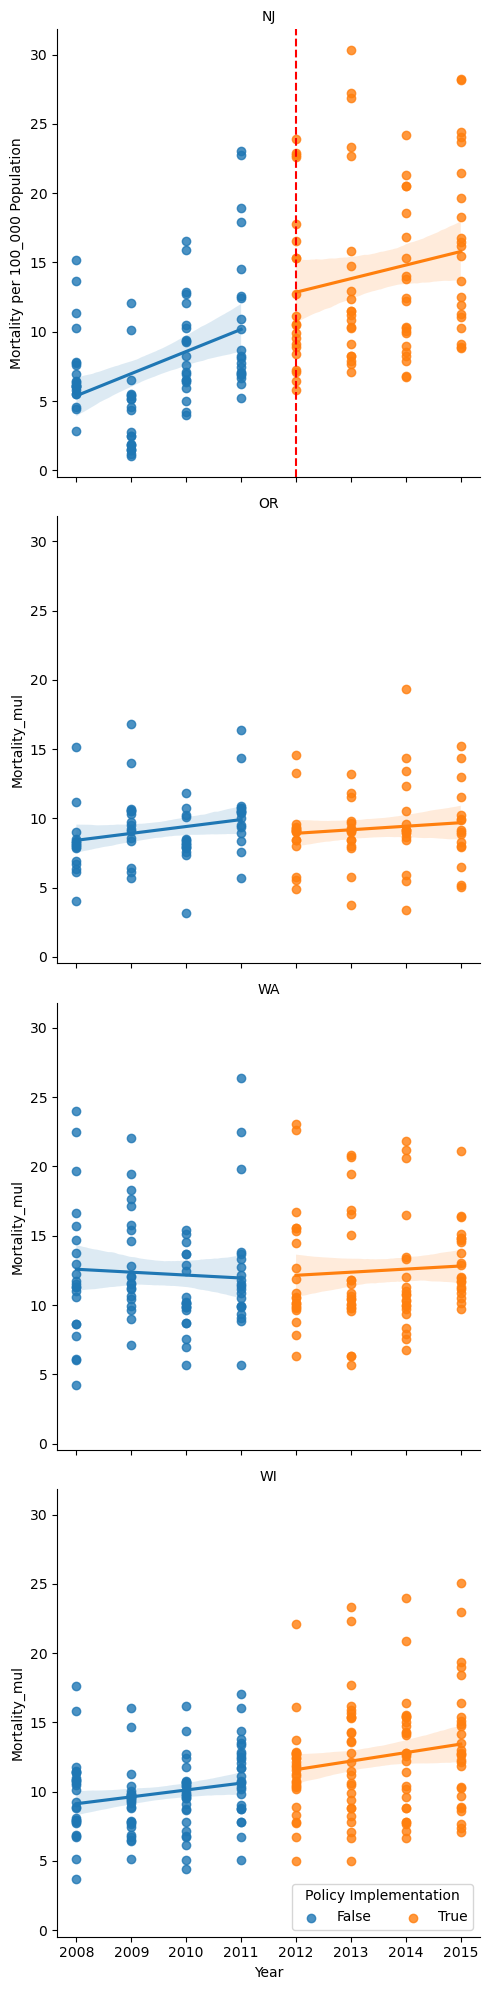

In [11]:
plot_all_states(mortality_plot, test_state, policy_year, "Mortality_mul")

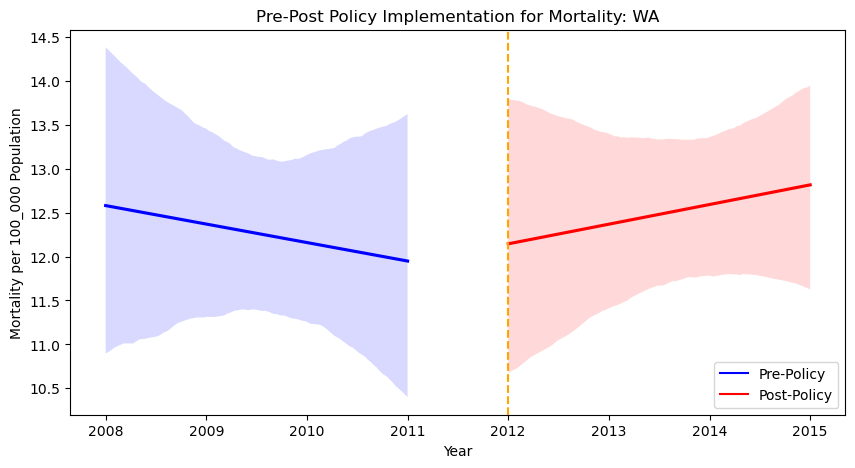

In [12]:
plot_pre_post_policy_graph(mortality_plot, test_state, policy_year, "Mortality_mul")

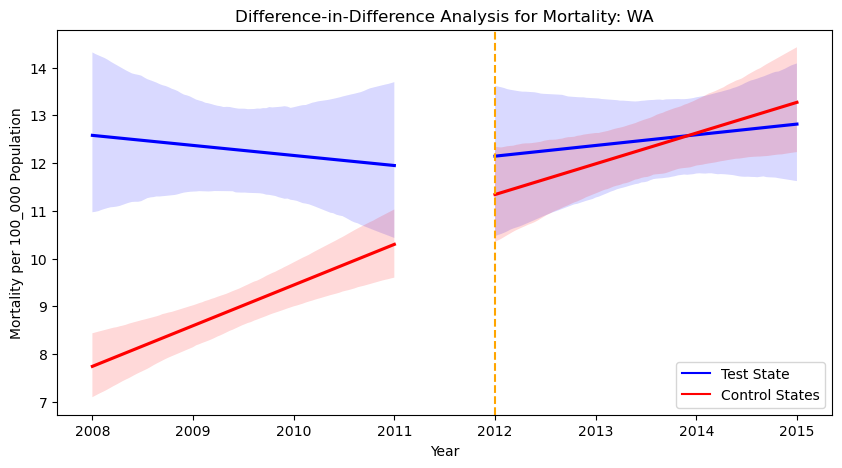

In [13]:
plot_diff_in_diff_graph(mortality_plot, test_state, policy_year, "Mortality_mul")

# Florida

In [14]:
# Creating control variables

# Enter the Test State Below
test_state = "FL"

# Enter list of states required below, Included the test state
control_states = ["GA", "NC", "LA"]

# Year control variable
policy_year = 2010  # year the policy was implemented
start_year = 2007  # desired start year for analysis
end_year = 2013  # desired end year for analysis

In [15]:
mortality_plot = prepare_data(
    mortality, test_state, control_states, policy_year, start_year, end_year
)
mortality_plot.sample(5)

,State,State_Code,County,County_Code,Year,Deaths,Population,Mortality_Rate,Mortality_mul,policy_implementation,State_Type
4178,Louisiana,LA,SAINT TAMMANY,22103,2012,40,239154.0,0.000167,16.725624,True,Control
7182,North Carolina,NC,BUNCOMBE,37021,2011,22,241226.0,0.000091,9.120078,True,Control
2292,Georgia,GA,EFFINGHAM,13103,2011,5,52709.0,0.000095,9.486046,True,Control
1612,Florida,FL,CITRUS,12017,2008,25,142122.0,0.000176,17.590521,False,Test
7443,North Carolina,NC,HALIFAX,37083,2012,5,53739.0,0.000093,9.304230,True,Control


/Users/revanth/miniconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


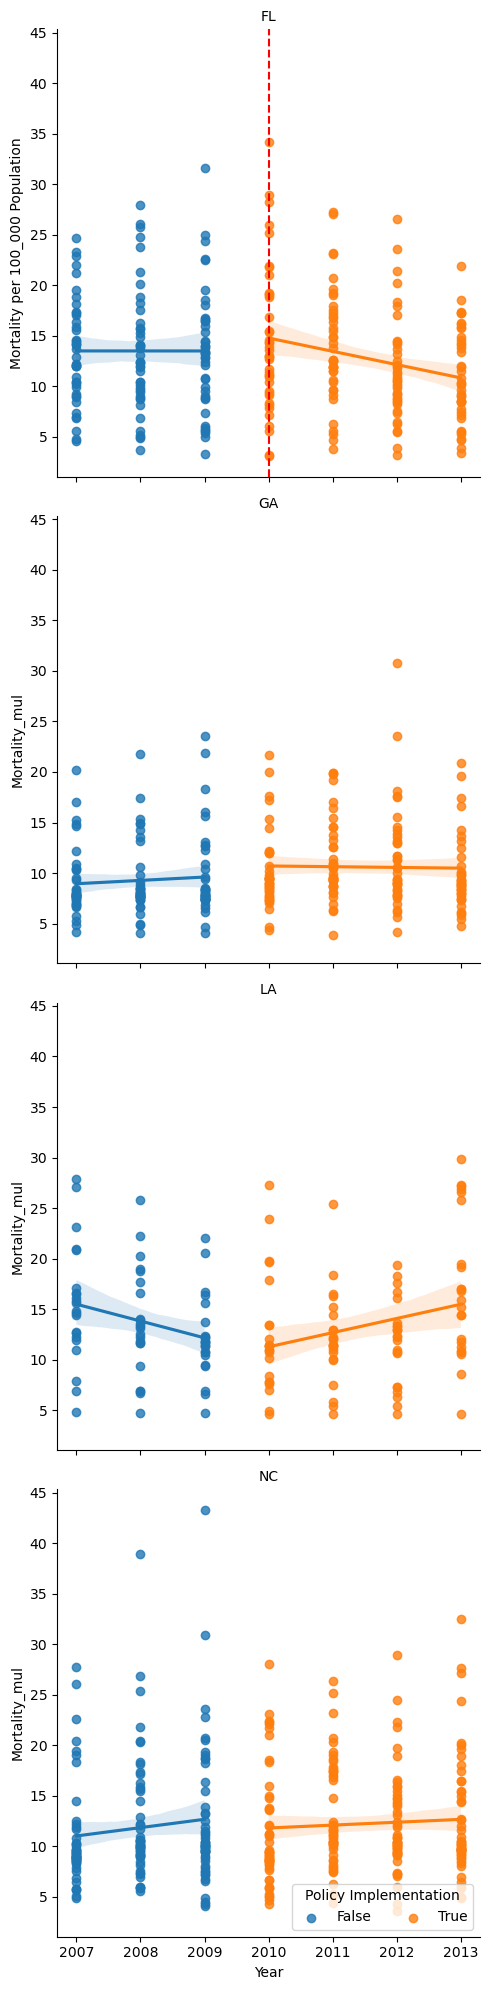

In [16]:
plot_all_states(mortality_plot, test_state, policy_year, "Mortality_mul")

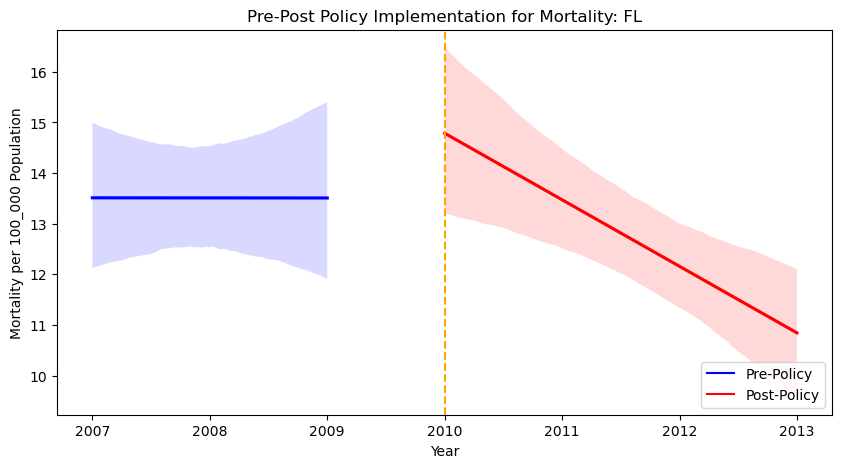

In [17]:
plot_pre_post_policy_graph(mortality_plot, test_state, policy_year, "Mortality_mul")

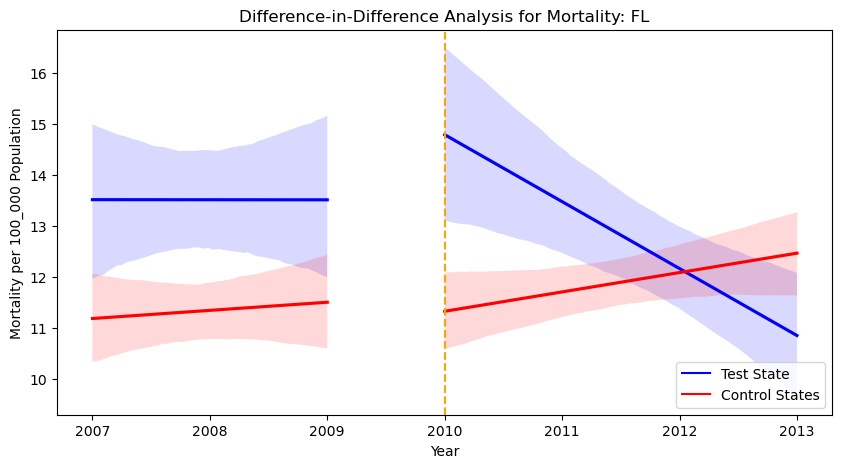

In [18]:
plot_diff_in_diff_graph(mortality_plot, test_state, policy_year, "Mortality_mul")

# Texas

In [24]:
# Creating control variables

# Enter the Test State Below
test_state = "TX"

# Enter list of states required below, Included the test state
control_states = ["LA", "AR", "OK", "MS", "AL", "AZ", "NM"]

# Year control variable
policy_year = 2007  # year the policy was implemented
start_year = 2003  # desired start year for analysis
end_year = 2011  # desired end year for analysis

In [25]:
mortality_plot = prepare_data(
    mortality, test_state, control_states, policy_year, start_year, end_year
)
mortality_plot.sample(5)

,State,State_Code,County,County_Code,Year,Deaths,Population,Mortality_Rate,Mortality_mul,policy_implementation,State_Type
8615,Oklahoma,OK,TULSA,40143,2007,125,582094.0,0.000215,21.474195,True,Control
6411,New Mexico,NM,DONA ANA,35013,2005,18,189199.0,0.000095,9.513792,False,Control
4054,Louisiana,LA,LAFOURCHE,22057,2003,9,91899.0,0.000098,9.793360,False,Control
219,Alabama,AL,MARSHALL,01095,2008,9,91072.0,0.000099,9.882291,True,Control
10721,Texas,TX,PARKER,48367,2003,13,97041.0,0.000134,13.396399,False,Test


/Users/revanth/miniconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


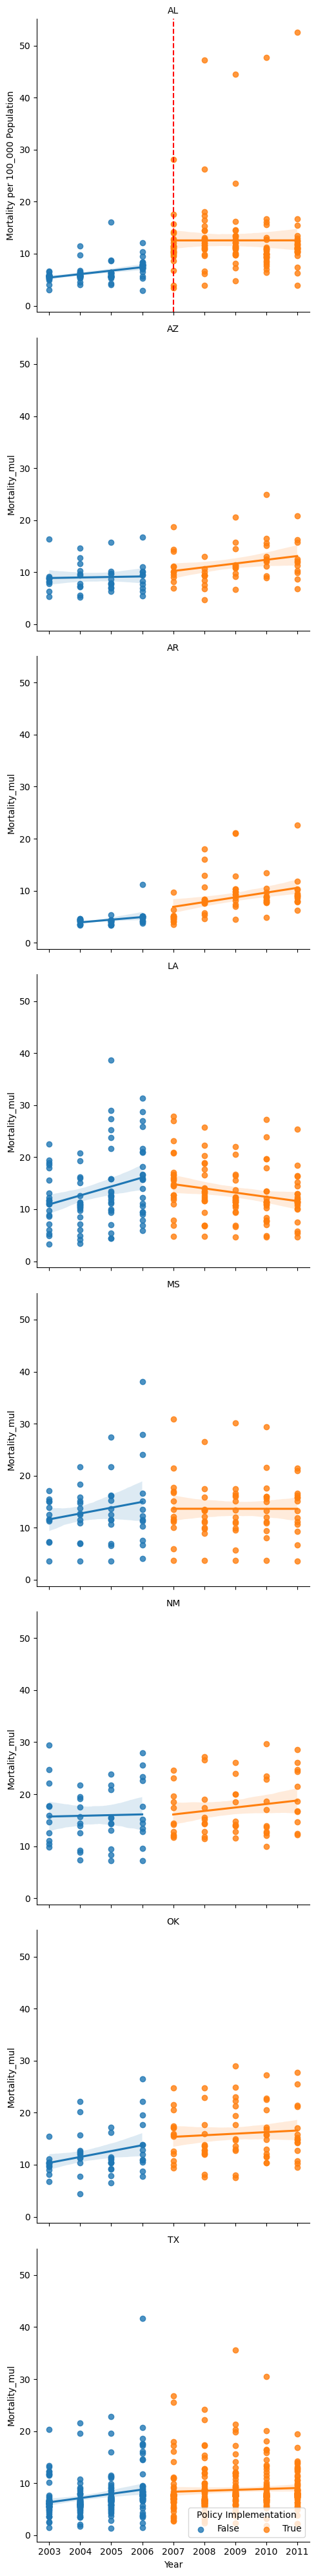

In [26]:
plot_all_states(mortality_plot, test_state, policy_year, "Mortality_mul")

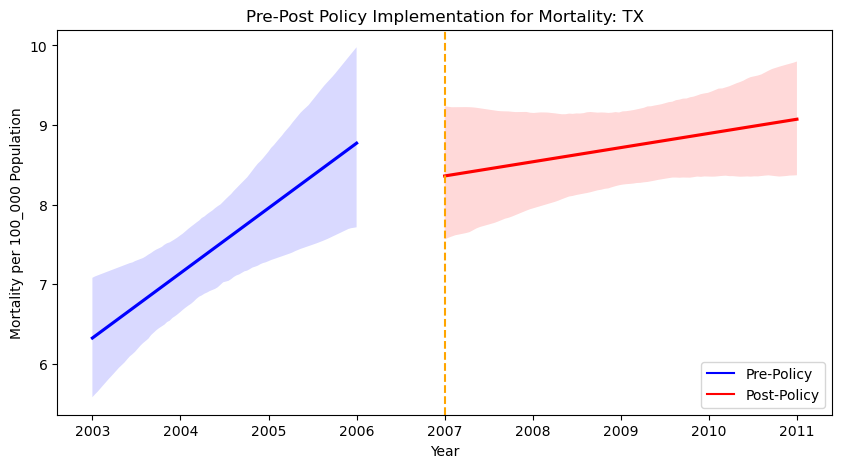

In [27]:
plot_pre_post_policy_graph(mortality_plot, test_state, policy_year, "Mortality_mul")

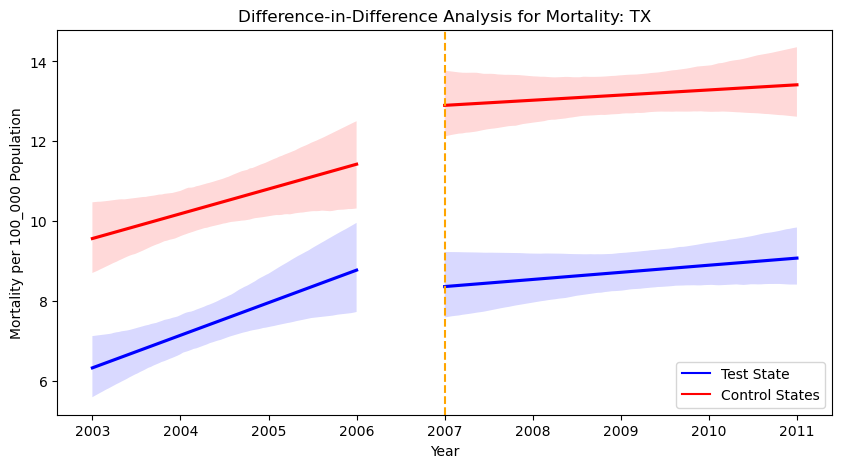

In [28]:
plot_diff_in_diff_graph(mortality_plot, test_state, policy_year, "Mortality_mul")